<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/find-weight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


plot prior

course cluster

one species warm start

# Preparation

In [1]:
%cd ../RADOM

# restrict numpy to use only one core, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from inference import Trajectory
from plotting import *

import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

/home/mffang/workspace/Poisson-regression/RADOM


## Load data

In [2]:
import scanpy

adata = scanpy.read('../data/hgForebrainGlut.loom')
adata.var_names_make_unique
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 1720 × 32738
    obs: 'Clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [3]:
clusters = adata.obs["Clusters"]
Clusters = set(clusters)
print(Clusters)
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))
cell_colors = colors20[np.mod(clusters, 20)]

{0, 1, 2, 3, 4, 5, 6}


/home/mffang/miniconda3/envs/python_3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


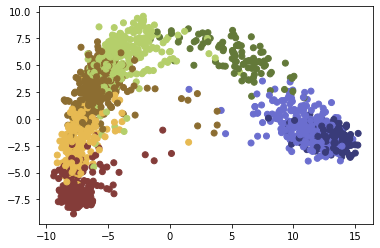

In [4]:
from sklearn.decomposition import PCA

total_UMI = adata.X.toarray().sum(axis=1)

pca = PCA(n_components=2)
x = pca.fit_transform(np.log(1+adata.X/total_UMI[:,None]*np.mean(total_UMI)))
plt.scatter(x[:,0],x[:,1],c=cell_colors)

In [5]:
marker_genes=["SOX2","SLC17A7","EOMES","CLU","FBXO32",
       "UNC5D","SEZ6","RBFOX1","DCX","GRIA3",
       "STMN2", "FAM64A","ELAVL4","RNASEH2B"]
marker_idx=adata.var_names.isin(marker_genes)

# Warm start

**Initiate weight using clusters**

In [6]:
m=100
t_grids=np.linspace(0,2,m)
weight0 = np.ones((adata.n_obs,m))
for i in Clusters:
    idx = clusters.isin([i])
    weight0[idx,int(i*m/7):int((i+1)*m/7)] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]

In [7]:
scanpy.pp.highly_variable_genes(adata,n_top_genes=100,flavor='seurat_v3')
idx = adata.var['highly_variable']
gene_list=adata.var_names[idx]

plot_mask = gene_list.isin(marker_genes)
plot_idx = np.arange(len(gene_list))[plot_mask]

gene_list[plot_mask]

Index(['EOMES', 'SOX2', 'CLU', 'FBXO32', 'STMN2'], dtype='object')

In [8]:
u=adata.layers["unspliced"][:,idx].toarray()
s=adata.layers["spliced"][:,idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s

In [9]:
tau=(0,1,2)
topo = np.array([[0,1]])
traj_ws = Trajectory(topo, tau, model="two_species", restrictions={}, verbose=1)
traj = traj_ws.fit(X, Q=Q0, epoch=100, parallel=True, n_threads=4)

run method fit_warm_start


 56%|█████▌    | 56/100 [00:27<00:21,  2.03it/s]


In [10]:
traj_ws.compute_AIC(X)

-1170976.0116327673

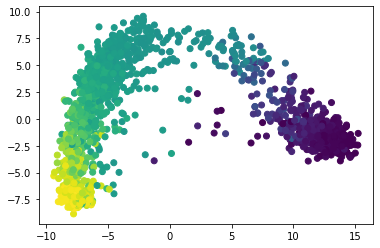

In [12]:
plt.scatter(x[:,0],x[:,1],c=traj_ws.Q[:,0]@traj_ws.t);

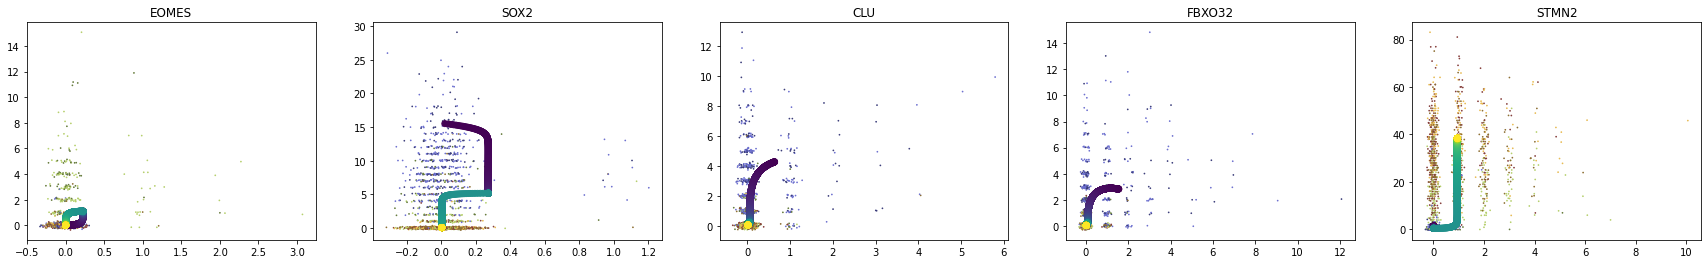

In [14]:
plot_phase(traj_ws, plot_idx, gene_list, cell_colors)

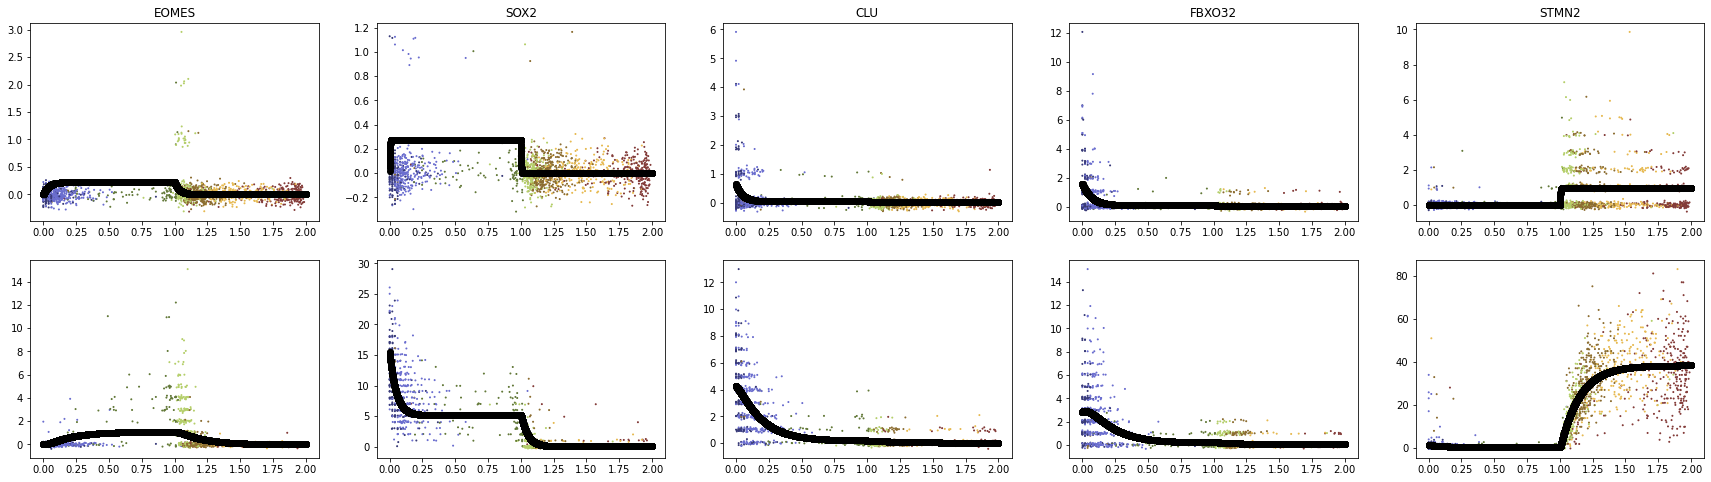

In [15]:
plot_y(traj_ws, plot_idx, gene_list, cell_colors)

In [16]:
accepts = []
diffs = []
model_restrictions = {}
for j in plot_idx:
    nested_model = {j:[[1],[0]]}
    accept, diff, _ = traj_ws.compare_model(X, nested_model)
    accepts.append(accept)
    diffs.append(diff)
    if accept:
        model_restrictions[j]=[[1],[0]]
accepts

100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


[False, False, True, False, False]

In [17]:
print(diffs)

[808.6574261325877, 356.6924383083824, -72.26041945721954, 29.169741832418367, 5085.129065315239]


In [18]:
accepts = []
diffs = []
model_restrictions = {}
for j in plot_idx:
    nested_model = {j:[[0],[-4]]}
    accept, diff, _ = traj_ws.compare_model(X, nested_model)
    accepts.append(accept)
    diffs.append(diff)
    if accept:
        model_restrictions[j]=[[0],[-4]]
accepts

100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


[False, False, False, False, True]

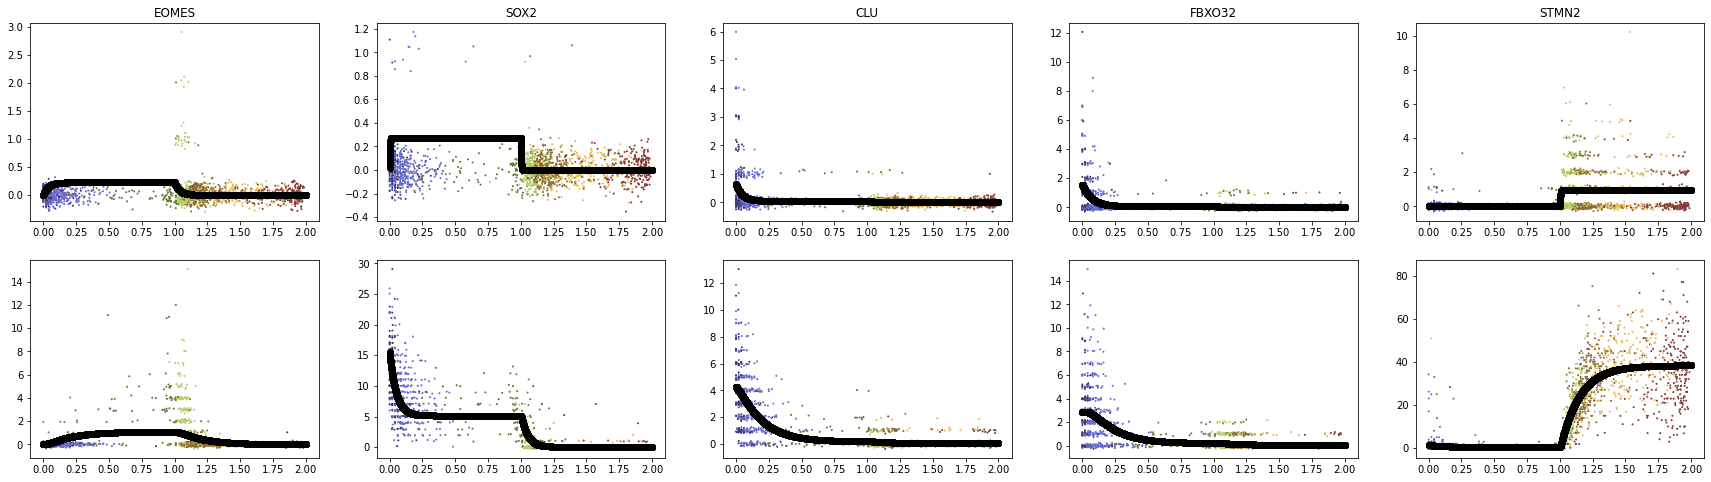

In [20]:
plot_y(_, plot_idx, gene_list, cell_colors)

In [21]:
accepts = []
diffs = []
model_restrictions = {}
for j in plot_idx:
    print(gene_list[j])
    nested_model = {j:[[1],[-4]]}
    accept, diff, _ = traj_ws.compare_model(X, nested_model)
    accepts.append(accept)
    diffs.append(diff)
    if accept:
        model_restrictions[j]=[[1],[-4]]
accepts

EOMES


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


SOX2


100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


CLU


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


FBXO32


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


STMN2


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


[True, True, False, False, False]

In [22]:
diffs

[-2.1368339818436652,
 -0.5509424898773432,
 217.1408214366529,
 574.9084200642537,
 160.84656166145578]

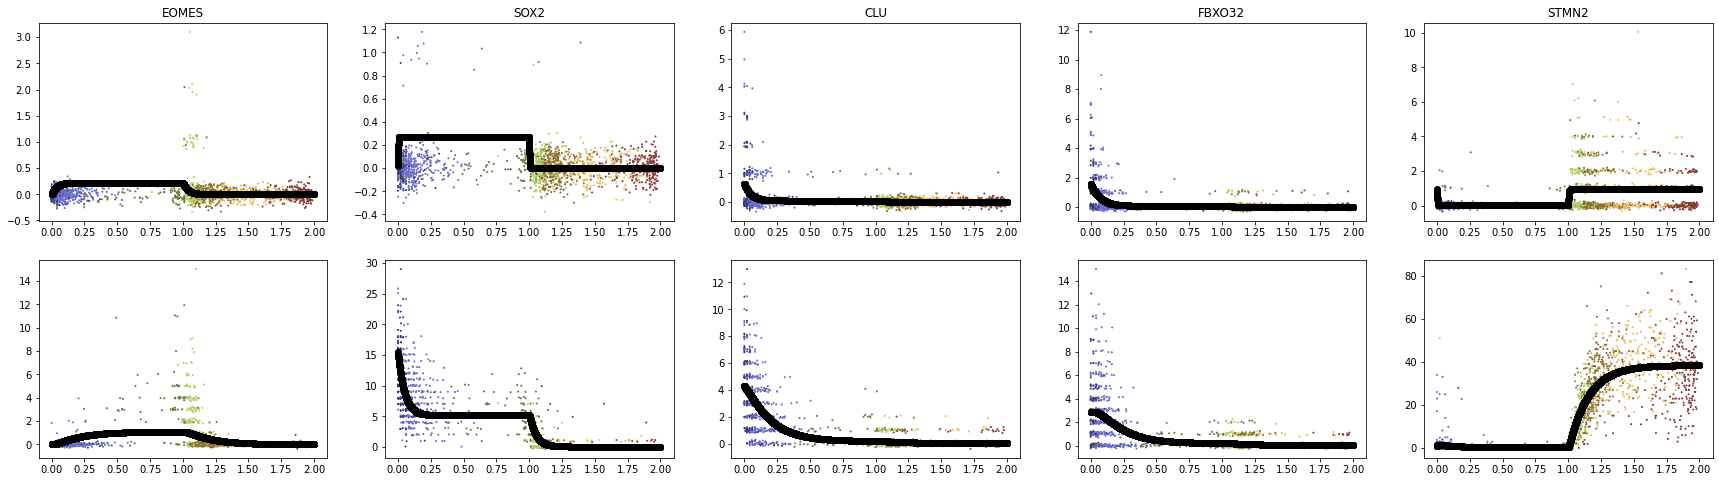

In [23]:
plot_y(_, plot_idx, gene_list, cell_colors)

# Random initializations

## Marker genes

In [24]:
gene_list=adata.var_names[marker_idx]
u=adata.layers["unspliced"][:,marker_idx].toarray()
s=adata.layers["spliced"][:,marker_idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s

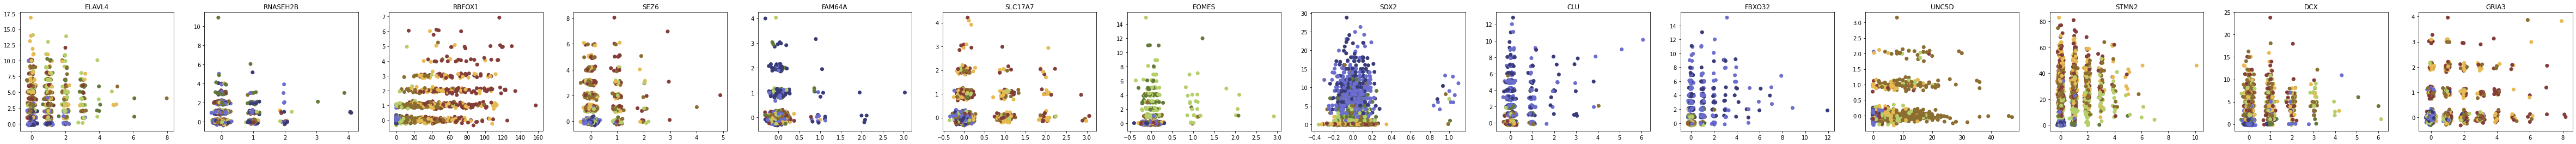

In [25]:
fig, ax = plt.subplots(1,14,figsize=(6*14,4))
for j in range(14):
    ax[j].scatter(X[:,j,0]+np.random.normal(scale=0.1,size=n),X[:,j,1]+np.random.normal(scale=0.1,size=n),c=cell_colors);
    ax[j].set_title(gene_list[j]);

### One species

In [26]:
X_one = s[:,:,None]
np.shape(X_one)

(1720, 14, 1)

In [27]:
tau=(0,1,2)
topo = np.array([[0,1]])
traj = Trajectory(topo, tau, model="one_species",verbose=1)
traj = traj.fit(X_one, n_init=3, parallel=True, n_threads=4)

run method fit_multi_init
trial 1


 20%|██        | 4/20 [00:00<00:02,  7.14it/s]

trial 2



 95%|█████████▌| 19/20 [00:02<00:00,  6.38it/s]

trial 3



 40%|████      | 8/20 [00:01<00:01,  7.48it/s]


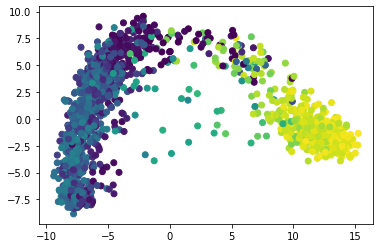

In [28]:
plt.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t);

### Two species

In [29]:
tau=(0,1,2)
topo = np.array([[0,1]])
traj = Trajectory(topo, tau, model="two_species")
traj = traj.fit(X, n_init=3, parallel=True, n_threads=4)
traj.compute_AIC(X)

-354459.7044079552

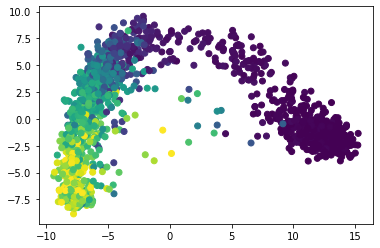

In [30]:
plt.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t);

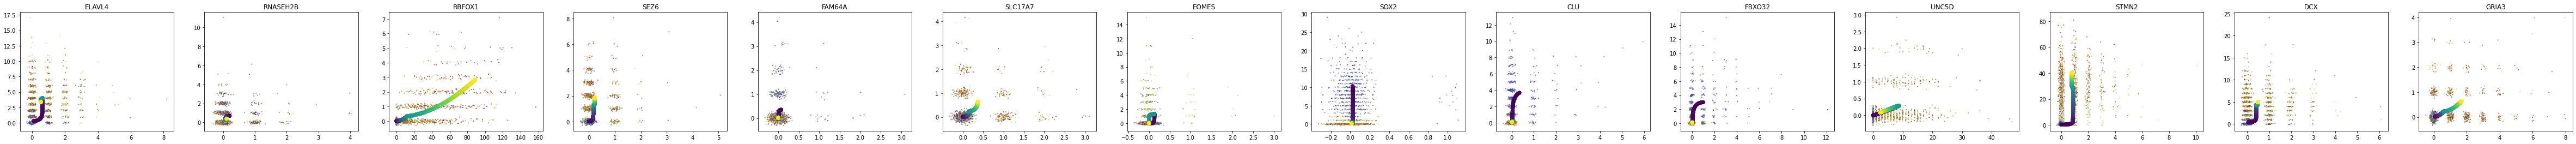

In [31]:
plot_phase(traj, np.arange(14), gene_list, cell_colors)

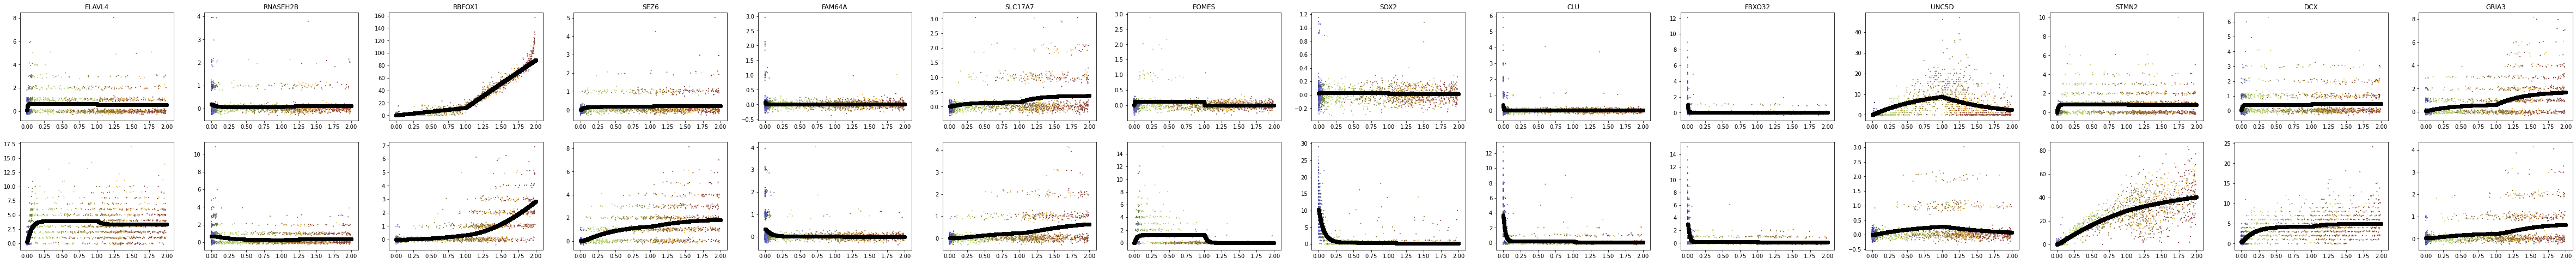

In [32]:
plot_y(traj, np.arange(14), gene_list, cell_colors)

**Check cell size** 

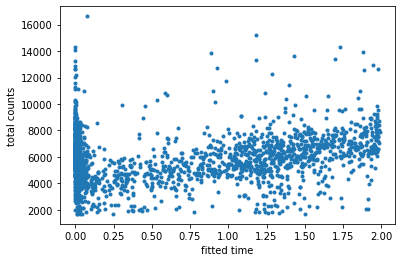

In [33]:
plt.plot(traj.Q[:,0]@traj.t,np.sum(adata.layers["spliced"],axis=1),'.')#,c=colors20[np.mod(clusters, 20)])
plt.ylabel("total counts");
plt.xlabel("fitted time");

### Two species starting from steady state

In [34]:
tau=(0,1,2)
topo = np.array([[0,1]])
traj = Trajectory(topo, tau, model="two_species_ss")
traj = traj.fit(X, n_init=3, parallel=True, n_threads=4)

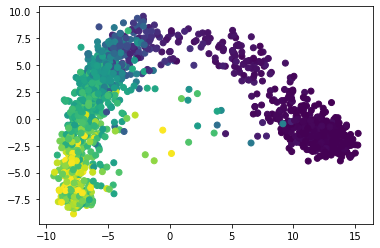

In [35]:
plt.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t);

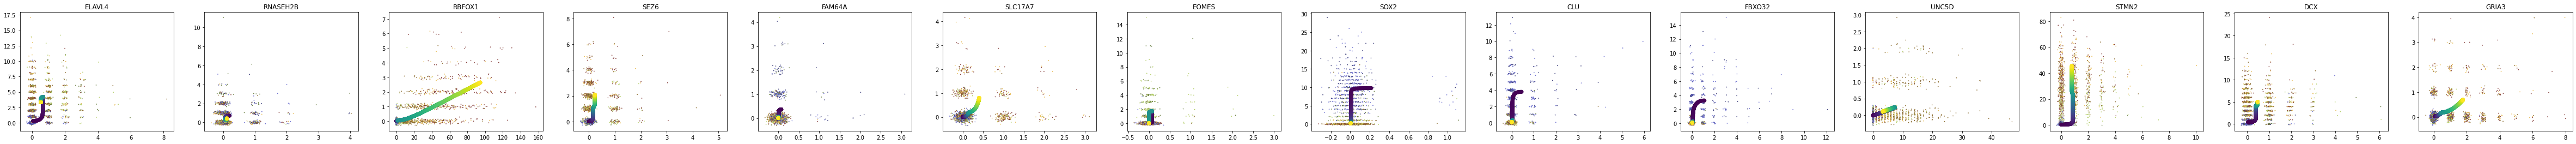

In [36]:
plot_phase(traj, np.arange(14), gene_list, cell_colors)

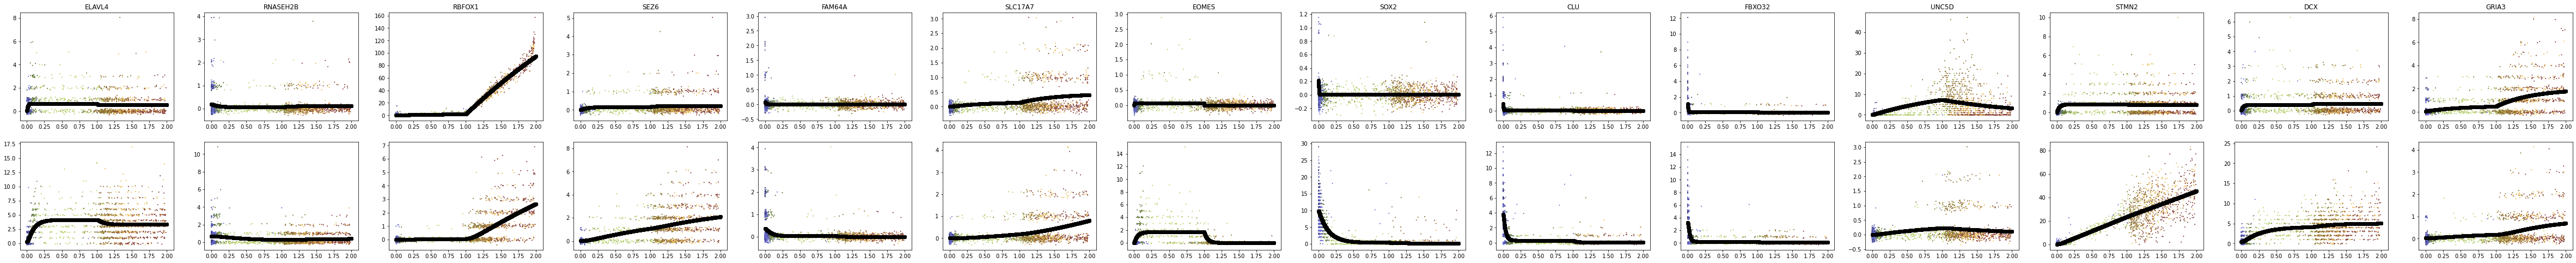

In [37]:
plot_y(traj, np.arange(14), gene_list, cell_colors)

In [38]:
traj.compute_AIC(X)

-355123.3306954776

## Genes with correlated U and S

In [39]:
def select_genes(U,S,gene_names,mean_min=0.1,var_min=1):
    gene_mask = (np.mean(S,axis=0)>0) & (np.mean(U,axis=0)>0) & (np.var(S,axis=0)>0) & (np.var(U,axis=0)>0)
    s = S[:,gene_mask]
    u = U[:,gene_mask]
    gene_names = gene_names[gene_mask]
    cov = np.cov(u,s,rowvar=False)
    s_mean = np.mean(s,axis=0)
    u_mean = np.mean(u,axis=0)
    X_mean = np.append(u_mean,s_mean)
    p = s.shape[1]
    rho = cov/X_mean[:,None]/X_mean[None,:]
    rho_s = rho[p:,p:]
    rho_u = rho[:p,:p]
    rho_us = rho[:p,p:]
    s = (np.sum(rho_us)-np.sum(np.diag(rho_us)))/(p-1)/p
    genes_mask = (s_mean>mean_min) & (u_mean>mean_min) & (np.abs(np.diag(rho_us)-s)>var_min)
    return gene_names[genes_mask]

In [40]:
U = adata.layers["unspliced"].toarray()
S = adata.layers["spliced"].toarray()
gene_list = select_genes(U,S,adata.var_names,mean_min=0.1,var_min=1)
len(gene_list)

122

In [41]:
idx=adata.var_names.isin(gene_list)
u=adata.layers["unspliced"][:,idx].toarray()
s=adata.layers["spliced"][:,idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s

In [42]:
plot_mask = gene_list.isin(marker_genes)
print(gene_list[plot_mask])
plot_idx = np.arange(len(gene_list))[plot_mask]

Index(['RBFOX1', 'FBXO32', 'UNC5D'], dtype='object')


### two_species

In [43]:
tau=(0,1,2)
topo = np.array([[0,1]])
traj = Trajectory(topo, tau, model="two_species")
traj = traj.fit(X, n_init=3, parallel=True, n_threads=4)

In [44]:
traj.compute_AIC(X)

-226916.98145613418

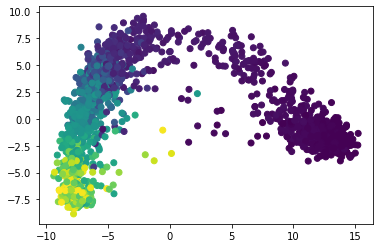

In [45]:
plt.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t);

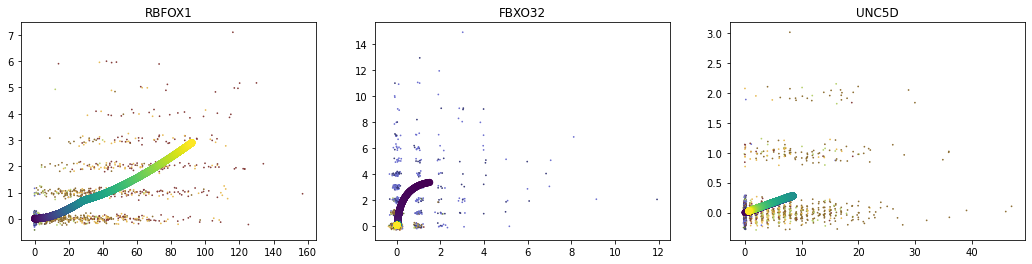

In [46]:
plot_phase(traj, plot_idx, gene_list, cell_colors)

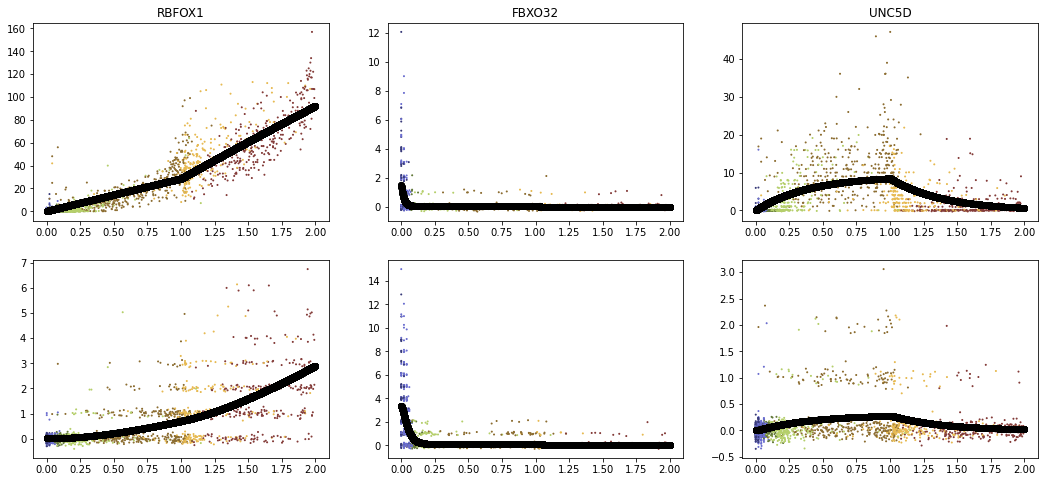

In [47]:
plot_y(traj, plot_idx, gene_list, cell_colors)

### two_species_ss

In [48]:
tau=(0,1,2)
topo = np.array([[0,1]])
traj = Trajectory(topo, tau, model="two_species_ss")
traj = traj.fit(X, n_init=3, parallel=True, n_threads=4)
traj.compute_AIC(X)

-223737.22421628513

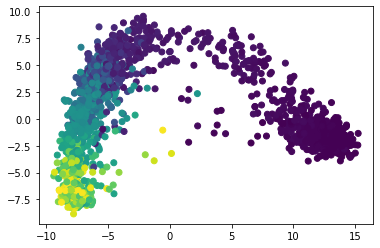

In [49]:
plt.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t);

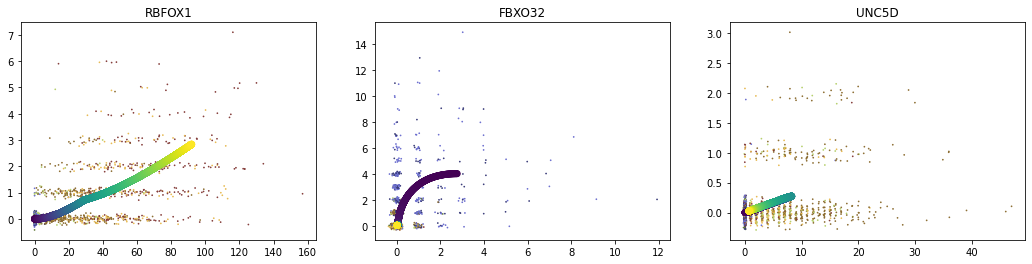

In [50]:
plot_phase(traj, plot_idx, gene_list, cell_colors)

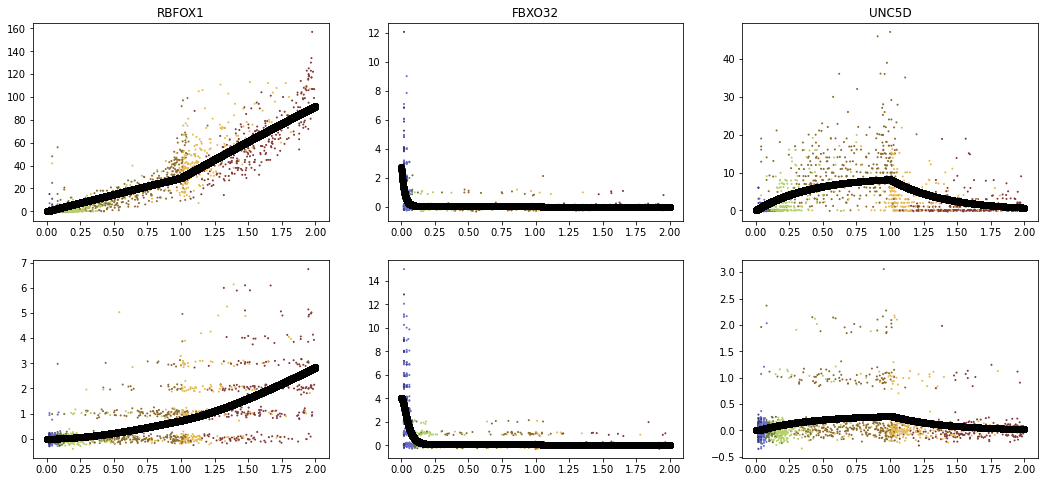

In [51]:
plot_y(traj, plot_idx, gene_list, cell_colors)

## scanpy highly_variable_genes

In [52]:
scanpy.pp.highly_variable_genes(adata,n_top_genes=50,flavor='seurat_v3')
idx = adata.var['highly_variable']
gene_list=adata.var_names[idx]

plot_mask = gene_list.isin(marker_genes)
plot_idx = np.arange(len(gene_list))[plot_mask]

gene_list[plot_mask]

Index(['EOMES', 'SOX2', 'STMN2'], dtype='object')

In [53]:
gene_list=adata.var_names[idx]
u=adata.layers["unspliced"][:,idx].toarray()
s=adata.layers["spliced"][:,idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s

In [63]:
tau=(0,1,2)
topo = np.array([[0,1]])
traj = Trajectory(topo, tau,  model="two_species_ss", restrictions={}, verbose=1)
traj = traj.fit(X, n_init=3, parallel=True, n_threads=2)

run method fit_multi_init
trial 1


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]

trial 2



100%|██████████| 20/20 [00:10<00:00,  1.90it/s]

trial 3



100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


In [64]:
traj.compute_AIC(X)

2055793.6542397288

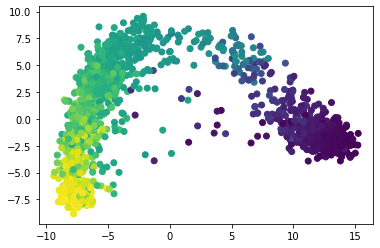

In [57]:
plt.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t);

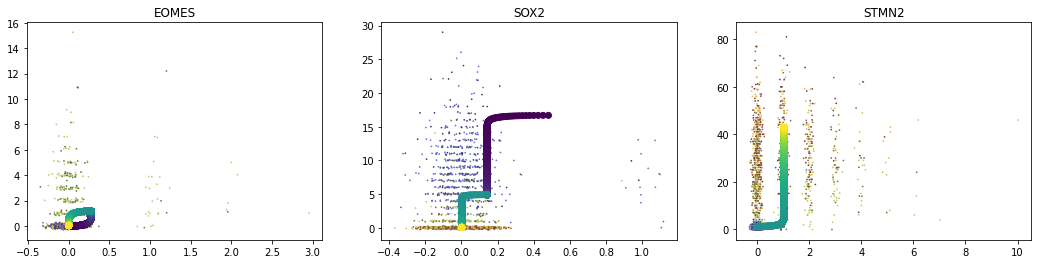

In [58]:
plot_phase(traj, plot_idx, gene_list, cell_colors)

In [59]:
tau=(0,1,2)
topo = np.array([[0,1]])
traj = Trajectory(topo, tau,  model="two_species", restrictions={}, verbose=1)
traj = traj.fit(X, n_init=3, parallel=True, n_threads=2)

run method fit_multi_init
trial 1


 80%|████████  | 16/20 [00:07<00:01,  2.19it/s]

trial 2



 95%|█████████▌| 19/20 [00:08<00:00,  2.28it/s]

trial 3



100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


In [60]:
traj.compute_AIC(X)

-896668.6466604953

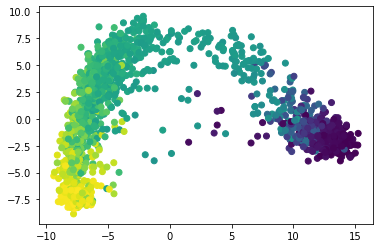

In [61]:
plt.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t);

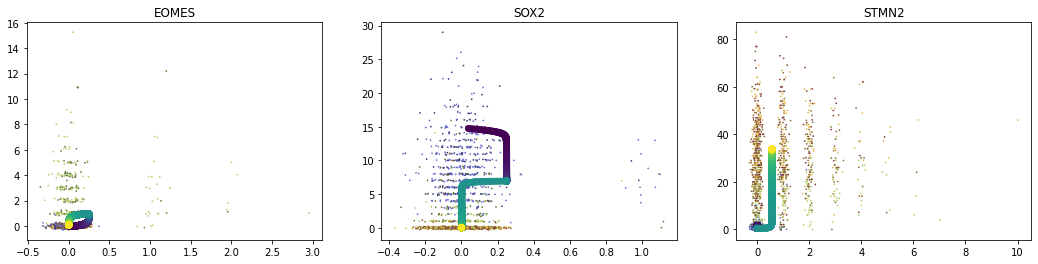

In [62]:
plot_phase(traj, plot_idx, gene_list, cell_colors)